In [1]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling_seg import ActiveTestVisionTransformer, CONFIGS

from utils.data_utils_feature import *

def read_one_results(path):
    with open(path, "r") as outfile:
        data = json.load(outfile)
    return data

def write_one_results(json_data, path):
    with open(path, "w") as outfile:
        json.dump(json_data, outfile)

def np_read(file):
    with open(file, "rb") as outfile:
        data = np.load(outfile)
    return data

## 16 X 16 region based loss estmation inference

In [2]:
%%capture
config = CONFIGS["ViT-B_16"]
config.input_feature_dim = 25
model = ActiveTestVisionTransformer(config, num_classes=50, zero_head=False, img_size=480, vis=True)
model_checkpoint = "./output/ViT-output-PSPNet-VOC-train-ordinal-new_checkpoint_3600.bin"
model.load_state_dict(torch.load(model_checkpoint))
model.eval()
split = "val"
model_data_path = "/workspace/pytorch-segmentation/pro_data/PSPNet_VOC/"
annotation_dir = model_data_path + split + "/image_true_losses.npy"
inputs_path = model_data_path + split
train_loader = FeatureDataset(inputs_path, annotation_dir, aug=False)
estimate_loss_list = None
for i in range(1449):
    feature, label = train_loader.__getitem__(i)
    patch_loss_estimation = model.forward_patch_result(feature.unsqueeze(0))
    estimated_loss = tensor_ordinal_to_float(patch_loss_estimation)
    estimated_loss = estimated_loss.numpy()
    if estimate_loss_list is None:
        estimate_loss_list = estimated_loss
    else:
        estimate_loss_list = np.concatenate((estimate_loss_list, estimated_loss))
    if (i+1)%100 == 0:
        print(f"Process {i}")
store_path = "./output/region_16_16/ViT-output-PSPNet-VOC-train-ordinal-new_losses_3600.json"
json_object = {"losses":estimate_loss_list.tolist()}
write_one_results(json_object, store_path)

## 8 X 8 region based loss estmation inference

In [2]:
%%capture
config = CONFIGS["ViT-B_8"]
config.input_feature_dim = 25
model = ActiveTestVisionTransformer(config, num_classes=50, zero_head=False, img_size=240, vis=True)
model_checkpoint = "./output/ViT-output-PSPNet-VOC-train-ordinal-8x8-patch_checkpoint_9800.bin"
model.load_state_dict(torch.load(model_checkpoint))
model.eval()

In [3]:
split = "val"
model_data_path = "/workspace/pytorch-segmentation/pro_data/PSPNet_VOC/"
annotation_dir = model_data_path + split + "/image_true_losses.npy"
inputs_path = model_data_path + split
train_loader = FeatureDataset(inputs_path, annotation_dir, aug=False)

In [5]:
estimate_loss_list = None
for i in range(1449):
    patch_estimated_loss = np.zeros((3600))
    feature, label, index = train_loader.get_item_with_indices(i)
    patch_loss_estimation = model.forward_patch_result(feature.unsqueeze(0))
    estimated_loss = tensor_ordinal_to_float_patch(patch_loss_estimation)
    estimated_loss = estimated_loss.numpy()
    patch_estimated_loss[index] = estimated_loss
    if estimate_loss_list is None:
        estimate_loss_list = patch_estimated_loss
    else:
        estimate_loss_list = np.concatenate((estimate_loss_list, patch_estimated_loss))
    if (i+1)%100 == 0:
        print(f"Process {i}")

Process 99
Process 199
Process 299
Process 399
Process 499
Process 599
Process 699
Process 799
Process 899
Process 999
Process 1099
Process 1199
Process 1299
Process 1399


In [7]:
store_path = "./output/region_8_8/ViT-output-PSPNet-VOC-train-ordinal-8x8-patch_losses_9800.json"
json_object = {"losses":estimate_loss_list.tolist()}
write_one_results(json_object, store_path)

## Analysis the relationship between entropy and loss for patch

In [29]:
5206433 / 3600

1446.231388888889

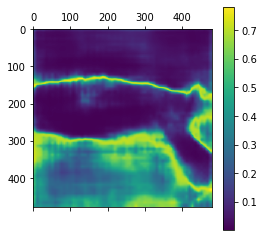

In [37]:
image_index = 88
feature_dir = "/workspace/pytorch-segmentation/pro_data/PSPNet_VOC/val/output/"
file_name = str(image_index // 8) + ".npy"
image_loc = image_index % 8
one_result = np_read_with_tensor_output(feature_dir + file_name)
feature = one_result[image_loc]
feature = F.softmax(feature, dim=0)
entropy = torch.sum(torch.mul(-feature, torch.log(feature + 1e-20)), dim=0).unsqueeze(dim=0)
display(entropy[0])

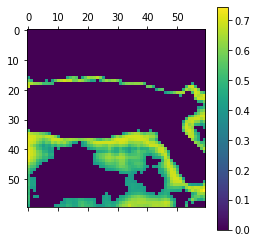

In [38]:
image_index = 88
entropy = np.zeros((3600))
feature, label, index = train_loader.get_item_with_indices(image_index)
# feature, label = train_loader.__getitem__(image_index)
def display(losses):
    plt.matshow(losses)
    plt.colorbar()
    plt.show()
avgpool = torch.nn.AdaptiveAvgPool2d((30,30))
sampled_entropy = feature[-1].unsqueeze(dim=0)
sampled_entropy = avgpool(sampled_entropy)
entropy[index] = torch.flatten(sampled_entropy)
entropy = entropy.reshape((60,60))
# entropy = avgpool(entropy)
display(entropy)

In [25]:
feature[-1].shape

torch.Size([240, 240])

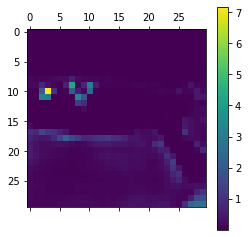

In [39]:
loss_dir = "/workspace/pytorch-segmentation/pro_data/PSPNet_VOC/val/loss/"
file_name = str(image_index // 8) + ".npy"
image_loc = image_index % 8
losses = np_read_with_tensor_output(loss_dir + file_name)
loss = losses[image_loc]
loss = torch.unsqueeze(loss, dim=0)
loss = avgpool(loss)
display(loss[0])

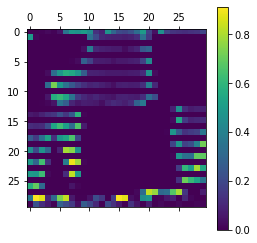

In [79]:
def display(losses):
    plt.matshow(losses)
    plt.colorbar()
    plt.show()
avgpool = torch.nn.AdaptiveAvgPool2d((30,30))
entropy = feature[-1].unsqueeze(dim=0)
entropy_patch = avgpool(entropy)
display(entropy_patch[0])

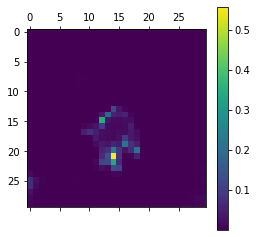

In [80]:
loss_dir = "/workspace/pytorch-segmentation/pro_data/PSPNet_VOC/val/loss/"
file_name = str(image_index // 8) + ".npy"
image_loc = image_index % 8
losses = np_read_with_tensor_output(loss_dir + file_name)
loss = losses[image_loc]
loss = torch.unsqueeze(loss, dim=0)
loss = avgpool(loss)
display(loss[0])